In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import beta
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

sns.set_theme("paper", "white")

In [2]:
df_users = pd.read_csv("./DSock/Active_Users.csv", index_col=0)
print(df_users.shape)
display(df_users.head())

(116, 55)


,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
1,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,2.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,NaN
2,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,4.0,1.0,NaN
3,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,NaN
4,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN
5,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,4.0,3.0,NaN


In [3]:
df_evals = pd.read_csv("./DSock/human_eval_analysis/attitude_tracking.csv")

df_evals = pd.merge(df_users, df_evals, how="left", left_on="MTurk_ID", right_on="id").rename({"id_x": "id"}, axis=1)

df_evals.index = [f"u{u}" for u in df_evals["id"]]

In [4]:
topics = list("abcdefgh")
deltas = ["10", "21", "32", "43", "54"]

In [5]:
timeline = pd.date_range("2020-09-03-03:59:59", periods=6, tz="utc")

get_change = lambda u, t: df_evals.loc[u][[f"{t}_delta_{d}" for d in deltas]].tolist()

In [6]:
u_change = {
    u: {t: (np.array(get_change(u, t)) != 0).sum() for t in topics}
    for u in df_evals.index
}

## get events

+ post events -> nodes
+ comment events -> nodes
+ view events -> nodes
+ like events -> nodes
+ influence -> edges

In [7]:
df_posts = pd.read_csv("./DSock/direct_influence/posts_with_senti_and_topic.csv", parse_dates=["createdAt"])
df_comts = pd.read_csv("./DSock/direct_influence/comments_with_senti_and_topic.csv", delimiter=",", parse_dates=["createdAt"]).dropna(subset=["CommenterId", "PostId"])
df_views = pd.read_csv("./DSock/postViews.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_likes = pd.read_csv("./DSock/Likes.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_repts = pd.read_csv("./DSock/ReportUsers.csv", delimiter="|", parse_dates=["createdAt"])

print(f"posts: {df_posts.shape}, comments: {df_comts.shape}, views: {df_views.shape}, likes: {df_likes.shape}, reports: {df_repts.shape}")

posts: (1057, 11), comments: (1615, 11), views: (234178, 10), likes: (1034, 6), reports: (46, 6)


In [8]:
df_likes["UserId"] = df_likes["UserId"].astype(int)
df_likes["PostId"] = df_likes["PostId"].astype(int)

df_comts["CommenterId"] = df_comts["CommenterId"].astype(int)
df_comts["PostId"] = df_comts["PostId"].astype(int)

In [9]:
df_likes.head()

,id,like,createdAt,updatedAt,UserId,PostId
0,48,t,2020-09-03 08:20:57.729000+00:00,2020-09-03 08:20:57.744+00,2443,107
1,24,t,2020-09-03 02:41:52.323000+00:00,2020-09-03 02:41:52.337+00,2580,98
2,25,t,2020-09-03 03:12:17.092000+00:00,2020-09-03 03:12:17.101+00,2622,107
3,77,t,2020-09-03 12:19:24.224000+00:00,2020-09-03 12:19:24.233+00,2481,127
4,26,t,2020-09-03 03:20:20.992000+00:00,2020-09-03 03:20:21.001+00,2604,100


### create influence graph

In [10]:
G = nx.DiGraph()
for u, uname, obsr, sock in df_users[["id", "username", "isObserver", "isPuppet"]].values:
    G.add_node(f"u{u}", id=u, kind="user", name=uname, observer=(obsr == "t"), sock=(sock == "t"))
    if obsr == "t":
        G.nodes[f"u{u}"]["color"] = "obsr"
    elif sock == "t":
        G.nodes[f"u{u}"]["color"] = "sock"
    else:
        G.nodes[f"u{u}"]["color"] = "part"

for p, u, t, polar, score, topic in df_posts[["PostID", "AuthorId", "createdAt", "labels", "scores", "topic_label"]].values:
    if f"u{u}" in G.nodes:
        G.add_node(f"p{p}", id=p, kind="post", time=t, user=u, polar=polar, score=score, topic=topic)

for c, u, t, polar, score, topic in df_comts[["id", "CommenterId", "createdAt", "labels", "scores", "topic_label"]].values:
    if f"u{u}" in G.nodes:
        G.add_node(f"p{c}", id=c, kind="comt", time=t, user=u, polar=polar, score=score, topic=topic)

for l, u, p, t in df_likes[["id", "UserId", "PostId", "createdAt"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"l{l}", user=f"u{u}", post=f"p{p}", time=t, id=l, kind="like",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"l{l}", f"u{u}", time=t, weight=1, kind="infer")
        G.add_edge(f"p{p}", f"l{l}", time=t, weight=1, kind="known")

for u, p, t, v in df_views[["UserId", "PostId", "createdAt", "id"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"v{v}", user=f"u{u}", post=f"p{p}", time=t, id=v, kind="view",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"v{v}", f"u{u}", time=t, weight=1, kind="infer")
        G.add_edge(f"p{p}", f"v{v}", time=t, weight=1, kind="known")

In [11]:
from tqdm.notebook import tqdm

In [12]:
user_view = {u: set() for u in G if u[0] == "u"}
for u, p, t, v in df_views[["UserId", "PostId", "createdAt", "id"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        user_view[f"u{u}"].add(f"v{v}")

In [13]:
for p in tqdm(G):
    if p[0] == "p":
        u = f"u{G.nodes[p]['user']}"
        for v in user_view[u]:
            if G.nodes[v]["time"] <= G.nodes[p]["time"]:
                G.add_edge(v, p, time=G.nodes[v]["time"], weight=1, kind="infer")

## On average, one user will read the same post almost 10 times!

In [14]:
up = [(G.nodes[n]["user"], G.nodes[n]["post"]) for n in G.nodes if n[0] == "v"]

print(f"{len(up)} {len(set(up))} {len(up)/len(set(up))}")

218540 22236 9.828206511962582


In [15]:
print(f"{len(G)} {len(G.edges)}")

221292 2831762


#### define colors and styles for graph drawing

In [16]:
use_color = sns.color_palette("tab10")
use_color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [17]:
line_map = {
    "view": "-",
    "like": ".",
}

color_map = {
    "view": 4,
    "like": 1,
    
    "known": 4,
    "infer": 6,
    
    "part": 2,
    "sock": 3,
    "obsr": 7,
    
    "make": 5,
    "comt": 9,
    "post": 0,
    
    "user": 8,
}

style_map = {
    "post": "o",
    "comt": "s",
}

In [18]:
node_name = "u2337"
topic = "a"

11


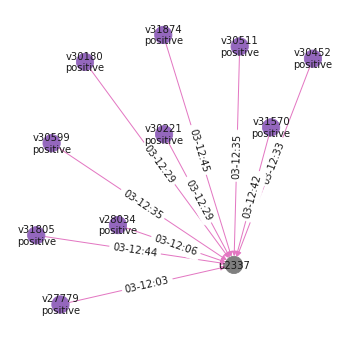

In [20]:
node_list = [e[0] for e in G.in_edges(node_name) if G.nodes[e[0]]["topic"] == topic][:10] + [node_name]
subG = nx.subgraph(G, node_list)

pos = nx.spring_layout(subG, seed=3)
# pos = nx.drawing.nx_agraph.graphviz_layout(subG, prog="dot")
fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

nx.draw(
    subG, ax=ax,
    pos=pos,
    with_labels=True,
    node_color=[use_color[color_map[subG.nodes[n]["kind"]]]
                if n[0] != "u" else use_color[color_map[subG.nodes[n]["color"]]]
                for n in subG.nodes],
    edge_color=[use_color[color_map[subG.edges[e]["kind"]]] for e in subG.edges],
    labels={n: f"{n}\n{subG.nodes[n]['polar']}" if subG.nodes[n]['kind'] != "user" else n for n in subG.nodes},
    font_size=10,
)

nx.draw_networkx_edge_labels(
    subG, pos=pos, ax=ax,
    edge_labels={e: f"{subG.edges[e]['time']:%d-%H:%M}" for e in subG.edges}
)

# ax.set_title(f"Direct influence graph")
print(f"{len(subG)}")

In [ ]:
user_timeline = {
    f"{node_name}_{i}": {
        "node": G.nodes[node_name],
        "time": timeline[i],
        "change": get_change(node_name, topic)[i-1] if i > 0 else 0,
    } for i in range(6)
}

print(user_timeline)

## full influence graph

In [23]:
node_name = "u2337"
topic = "h"
polarity = "positive"

ancestor_full = [n for n in nx.ancestors(G, node_name)
                if G.nodes[n]["topic"] == topic and G.nodes[n]["polar"] == polarity]

np.random.seed(4)
# descend_full = np.random.choice(descend_full, 65, replace=False).tolist()

subG = G.subgraph(ancestor_full + [node_name]).copy()
print(len(subG))

subG = subG.subgraph([n for n in subG if nx.has_path(subG, n, node_name)])
print(len(subG))

5499
811


/home/rui/venvs/gcn/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: obsr is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


811


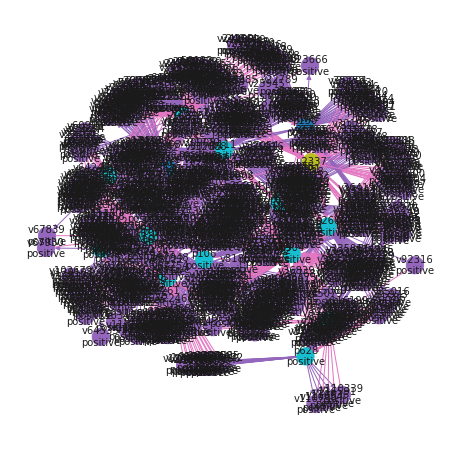

In [24]:
# pos = nx.spring_layout(subG, iterations=6, seed=3)
pos = nx.drawing.nx_agraph.graphviz_layout(subG, prog="dot")
pos = nx.drawing.nx_agraph.graphviz_layout(subG)

fig = plt.figure(figsize=(8, 8))
ax = fig.subplots()

nx.draw(
    subG, ax=ax,
    pos=pos,
    with_labels=True,
    node_color=[use_color[color_map[subG.nodes[n]["kind"]]] for n in subG.nodes],
    edge_color=[use_color[color_map[subG.edges[e]["kind"]]] for e in subG.edges],
    labels={n: f"{n}\n{subG.nodes[n]['polar']}" if subG.nodes[n]['kind'] != "user" else n for n in subG.nodes},
    font_size=10,
)

# nx.draw_networkx_edge_labels(
#     subG, pos=pos, ax=ax,
#     edge_labels={e: f"{subG.edges[e]['time']:%d-%H:%M}" for e in subG.edges},
#     font_size=8,
# )

print(len(subG))

811


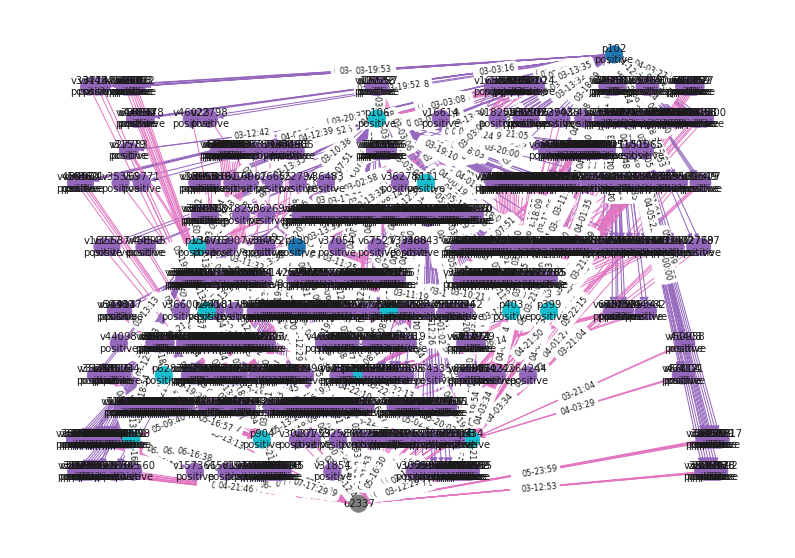

In [26]:
# pos = nx.spring_layout(subG, iterations=100)
pos = nx.drawing.nx_agraph.graphviz_layout(subG, prog="dot")

fig = plt.figure(figsize=(14, 10))
ax = fig.subplots()

nx.draw(
    subG, ax=ax,
    pos=pos,
    with_labels=True,
#     node_color=[use_color[color_map[subG.nodes[n]["kind"]]] for n in subG.nodes],
    node_color=[use_color[color_map[subG.nodes[n]["kind"]]]
                if n[0] != "u" else use_color[color_map[subG.nodes[n]["color"]]]
                for n in subG.nodes],
    edge_color=[use_color[color_map[subG.edges[e]["kind"]]] for e in subG.edges],
    labels={n: f"{n}\n{subG.nodes[n]['polar']}" if subG.nodes[n]['kind'] != "user" else n for n in subG.nodes},
    font_size=10,
)

nx.draw_networkx_edge_labels(
    subG, pos=pos, ax=ax,
    edge_labels={e: f"{subG.edges[e]['time']:%d-%H:%M}" for e in subG.edges},
    font_size=8,
)

print(len(subG))

In [65]:
attention_window = pd.Timedelta("1 day")
moment_time = timeline[5]
topic = "h"
pr_alpha = 0.85
beta_rv = beta(a=0.5, b=0.5)

node_name = "u2337"
polarity="positive"

print(f"{attention_window}, {moment_time}")

1 days 00:00:00, 2020-09-08 03:59:59+00:00


In [66]:
moment_nodes = [n for n in nx.ancestors(G, node_name)
                if G.nodes[n]["topic"] == topic and G.nodes[n]["polar"] == polarity] + [node_name]

moment_graph = G.subgraph(moment_nodes).copy()
print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")
moment_graph.nodes[node_name]["time"] = moment_time

# remove edges outside attention window
remove_edges = [e for e in moment_graph.edges if moment_graph.edges[e]["time"] > moment_time]
for n in moment_graph:
    if n[0] in ["p", "u"]:
        t = moment_graph.nodes[n]["time"]
        remove_edges += [e for e in moment_graph.in_edges(n) if not t - attention_window < moment_graph.edges[e]["time"] <= t]

print(f"remove edges {len(remove_edges)}")
moment_graph.remove_edges_from(remove_edges)
print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")

# for source node node_name only
moment_graph = moment_graph.subgraph([n for n in moment_graph if nx.has_path(moment_graph, n, node_name)]).copy()
print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")

# remove isolated nodes
isolates = list(nx.isolates(moment_graph))
moment_graph.remove_nodes_from(isolates)
print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")


for node in moment_graph:
    elist = sorted(moment_graph.out_edges(node), key=lambda e: G.edges[e]["time"])
    x = np.linspace(0, 1, len(elist)+2)[1:-1]
    y = beta_rv.pdf(x)
    y = y / y.sum()
    for e, w in zip(elist, y):
        moment_graph.edges[e]["weight"] = w

pr_value = nx.pagerank_numpy(moment_graph.reverse(), alpha=pr_alpha, weight="weight")

nodes 5499, edges: 6630
remove edges 510
nodes 5499, edges: 6120
nodes 422, edges: 847
nodes 422, edges: 847


422


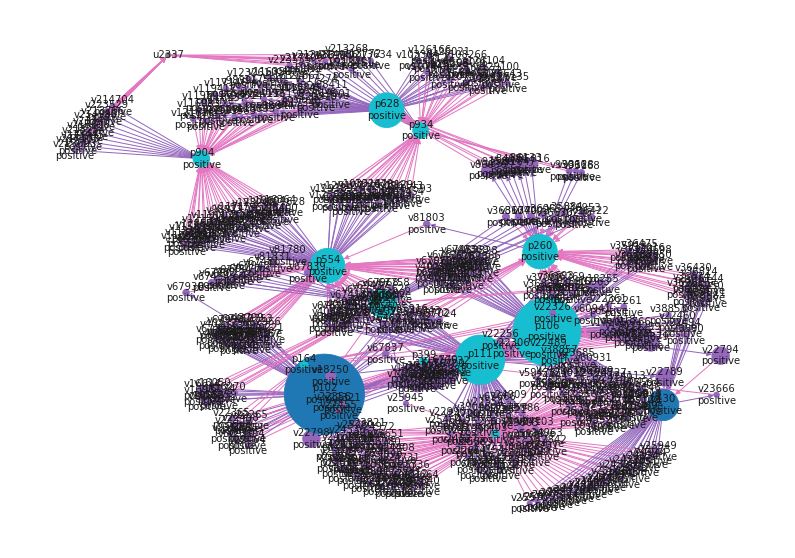

In [67]:
# pos = nx.drawing.nx_agraph.graphviz_layout(moment_graph, prog="dot")
pos = nx.drawing.nx_agraph.graphviz_layout(moment_graph)
# pos = nx.spring_layout(moment_graph, iterations=3, seed=3)

fig = plt.figure(figsize=(14, 10))
ax = fig.subplots()

nx.draw(
    moment_graph, ax=ax,
    pos=pos,
    with_labels=True,
#     node_color=[use_color[color_map[moment_graph.nodes[n]["kind"]]] for n in moment_graph.nodes],
    node_color=[use_color[color_map[moment_graph.nodes[n]["kind"]]]
                if n[0] != "u" else use_color[color_map[moment_graph.nodes[n]["color"]]]
                for n in moment_graph.nodes],
    edge_color=[use_color[color_map[moment_graph.edges[e]["kind"]]] for e in moment_graph.edges],
    labels={n: f"{n}\n{moment_graph.nodes[n]['polar']}" if moment_graph.nodes[n]['kind'] != "user" else n for n in moment_graph.nodes},
    font_size=10,
    node_size=[pr_value[n]*len(moment_graph)*100 for n in moment_graph],
)

nx.draw_networkx_edge_labels(
    subG, pos=pos, ax=ax,
#     edge_labels={e: f"{moment_graph.edges[e]['time']:%d-%H:%M}" for e in moment_graph.edges},
    edge_labels={e: "" for e in moment_graph.edges},
    font_size=8,
)

print(len(moment_graph))

In [55]:
def compute_pagerank(G, node_name, pr_alpha, beta_a, beta_b, moment_time, attention_window, topic=None, polarity=None):
    moment_nodes = [n for n in nx.ancestors(G, node_name) 
                    if G.nodes[n]["topic"] == topic and G.nodes[n]["polar"] == polarity] + [node_name]

    moment_graph = G.subgraph(moment_nodes).copy()
    print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")
    moment_graph.nodes[node_name]["time"] = moment_time

    # remove edges outside attention window
    remove_edges = [e for e in moment_graph.edges if moment_graph.edges[e]["time"] > moment_time]
    for n in moment_graph:
        if n[0] in ["p", "u"]:
            t = moment_graph.nodes[n]["time"]
            remove_edges += [e for e in moment_graph.in_edges(n) if not t - attention_window < moment_graph.edges[e]["time"] <= t]

    print(f"remove edges {len(remove_edges)}")
    moment_graph.remove_edges_from(remove_edges)
    print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")

    # for source node node_name only
    moment_graph = moment_graph.subgraph([n for n in moment_graph if nx.has_path(moment_graph, n, node_name)]).copy()
    print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")

    # remove isolated nodes
    isolates = list(nx.isolates(moment_graph))
    moment_graph.remove_nodes_from(isolates)
    print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")


    for node in moment_graph:
        elist = sorted(moment_graph.out_edges(node), key=lambda e: G.edges[e]["time"])
        x = np.linspace(0, 1, len(elist)+2)[1:-1]
        y = beta_rv.pdf(x)
        y = y / y.sum()
        for e, w in zip(elist, y):
            moment_graph.edges[e]["weight"] = w

    pr_value = nx.pagerank_numpy(moment_graph.reverse(), alpha=pr_alpha, weight="weight")
    return pr_value, moment_graph

In [61]:
attention_window = pd.Timedelta("1 day")
moment_time = timeline[5]
topic = "h"
polarity = "positive"
pr_alpha = 0.85
beta_rv = beta(a=0.5, b=0.5)

node_name = "u2337"

pr_value, moment_graph = compute_pagerank(G, node_name=node_name, pr_alpha=pr_alpha, beta_a=0.5, beta_b=0.5, moment_time=moment_time, attention_window=attention_window, topic=topic, polarity=polarity)

nodes 5499, edges: 6630
remove edges 510
nodes 5499, edges: 6120
nodes 422, edges: 847
nodes 422, edges: 847


In [ ]:
obsr_list = [f"u{u}" for u in df_users[df_users["isObserver"] == "t"]["id"]]

In [ ]:
from tqdm.notebook import tqdm
# from multiprocessing import Pool
from joblib import Parallel, delayed
from pathlib import Path

In [ ]:
keyq = [(node_name, t, pr_alpha, beta_a, beta_b)
    for node_name in obsr_list for t in timeline[1:]
    for pr_alpha, beta_a, beta_b in itertools.product(np.linspace(0.1, 0.9, 5), np.linspace(0.1, 0.9, 5), np.linspace(0.1, 0.9, 5))
       ]

print(f"jobs: {len(keyq)}")

In [ ]:
def short_compute_pagerank(n, p, a, b, t):
    return compute_pagerank(
    G, node_name=n, pr_alpha=p, beta_a=a, beta_b=b, moment_time=t, attention_window=attention_window, topic=None)

pr_dict_fp = Path("res/pr_dict.pkl")

if pr_dict_fp.exists():
    print("load from file")
    with open(pr_dict_fp, "rb") as fp:
        pr_dict = pickle.load(fp)
else:
    print("generate and save to file")
    valueq = Parallel(n_jobs=30)(delayed(short_compute_pagerank)(*tup) for tup in tqdm(keyq))

# valueq = pool.starmap(
#     func=short_compute_pagerank,
#     iterable=tqdm(keyq),
#     chunksize=1,
# )

### big number of values to compute
In total, there will be **21,250** jobs

+ Number of survey time for each user: 5
+ Number of observers: 34
+ Number of parameters
    - Pagerank damping factor: 5
    - Beta alpha, beta: 5*5=25

In [ ]:
import pickle

In [ ]:
with open("res/pr_dict.pkl", "wb") as fp:
    dictq = dict(zip(keyq, [v[0] for v in valueq]))
    pickle.dump(dictq, fp)